# GBM
- Data Split 
    - Apply 80/20 split by Ticker
    - For calculating performance, use 5 fold cross validation (RMSE, Accuracy (1 if positive, 0 if not))
- Build GBM by Ticker

In [422]:
import xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [423]:
TICKER = "JPM"
TEST_FRAC = 0.20
RESPONSE_VAR = "close_t+5"

In [424]:
df = pd.read_parquet("../data/processed/daily_with_finbert_and_indicators.parquet")

In [425]:
df["ticker"].unique()

array(['AAPL', 'AMZN', 'HD', 'JPM', 'KO', 'MSFT', 'NVDA', 'TSLA', 'UNH',
       'XOM'], dtype=object)

In [426]:
df = df.query(f"ticker == '{TICKER}'").reset_index(drop=True)

In [427]:
df.shape

(249, 805)

In [428]:
df.head()

,ticker,date,open,high,low,close,volume,return_t+1,headlines,finbert_0,...,open_smoothed_alpha:0.9,close_smoothed_alpha:0.25,close_smoothed_alpha:0.75,close_smoothed_alpha:0.9,return_t+1_smoothed_alpha:0.25,return_smoothed_alpha:0.25,return_t+1_smoothed_alpha:0.75,return_smoothed_alpha:0.75,return_t+1_smoothed_alpha:0.9,return_smoothed_alpha:0.9
0,JPM,2024-05-01,192.270004,194.460007,190.789993,191.860001,7445300.0,-0.001042,[],0.000000,...,192.270004,191.860001,191.860001,191.860001,-0.001042,0.002769,-0.001042,0.004086,-0.001042,0.004239
1,JPM,2024-05-02,193.070007,193.500000,189.520004,191.660004,6501700.0,-0.006000,[],0.000000,...,192.990007,191.810001,191.710003,191.680003,-0.002282,-0.001042,-0.004761,-0.001042,-0.005504,-0.001042
2,JPM,2024-05-03,192.000000,192.529999,188.460007,190.509995,8922800.0,0.007821,[],0.000000,...,192.099001,191.485000,190.809997,190.626995,0.000244,-0.002282,0.004676,-0.004761,0.006489,-0.005504
3,JPM,2024-05-06,191.729996,192.199997,189.820007,192.000000,7911100.0,-0.001302,[],0.000000,...,191.766896,191.613750,191.702499,191.862700,-0.000143,0.000244,0.000192,0.004676,-0.000523,0.006489
4,JPM,2024-05-07,191.699997,192.929993,191.649994,191.750000,7688800.0,0.020339,[JPMorgan just gave itself an $8 billion boost...,0.243642,...,191.706687,191.647812,191.738125,191.761270,0.004978,-0.000143,0.015302,0.000192,0.018253,-0.000523


In [429]:
df.tail()

,ticker,date,open,high,low,close,volume,return_t+1,headlines,finbert_0,...,open_smoothed_alpha:0.9,close_smoothed_alpha:0.25,close_smoothed_alpha:0.75,close_smoothed_alpha:0.9,return_t+1_smoothed_alpha:0.25,return_smoothed_alpha:0.25,return_t+1_smoothed_alpha:0.75,return_smoothed_alpha:0.75,return_t+1_smoothed_alpha:0.9,return_smoothed_alpha:0.9
244,JPM,2025-04-23,240.220001,246.789993,240.000000,240.880005,14126800.0,0.015609,[Ultimate Insider Marjorie Taylor Greene’s Top...,0.280930,...,239.382832,234.168409,239.186018,240.287776,0.011279,0.009835,0.017136,0.021716,0.016318,0.022695
245,JPM,2025-04-24,239.740005,245.470001,237.580002,244.639999,9055200.0,-0.004456,[Stocks Fluctuate on Tariff Concern as Dollar ...,0.088710,...,239.704288,236.786306,243.276504,244.204777,0.007345,0.011279,0.000942,0.017136,-0.002378,0.016318
246,JPM,2025-04-25,244.649994,245.619995,241.750000,243.550003,8588600.0,-0.001355,[EVT: Attractive Discount Combined With Market...,-0.006047,...,244.155423,238.477230,243.481628,243.615480,0.005170,0.007345,-0.000781,0.000942,-0.001457,-0.002378
247,JPM,2025-04-28,244.559998,246.839996,240.839996,243.220001,7394300.0,0.005756,[US Boosts Net Quarterly Borrowing Estimate to...,-0.054886,...,244.519540,239.662923,243.285408,243.259549,0.005317,0.005170,0.004122,-0.000781,0.005035,-0.001457
248,JPM,2025-04-29,242.190002,245.250000,241.690002,244.619995,7216800.0,0.000000,[Oil Tumbles as Trump’s Trade War Pummels Outl...,0.030770,...,242.422956,240.902191,244.286348,244.483951,0.003988,0.005317,0.001030,0.004122,0.000503,0.005035


## Add Close @ T+1 as a variable to test modeling

In [430]:
for lag in range(1, 6):
    df[f"close_t+{lag}"] = df["close"].shift(-lag)

In [431]:
df[["close", "close_t+1", "close_t+3", "close_t+5"]].head(10)

,close,close_t+1,close_t+3,close_t+5
0,191.860001,191.660004,192.000000,195.649994
1,191.660004,190.509995,191.750000,197.500000
2,190.509995,192.000000,195.649994,198.770004
3,192.000000,191.750000,197.500000,198.729996
4,191.750000,195.649994,198.770004,201.509995
5,195.649994,197.500000,198.729996,202.110001
6,197.500000,198.770004,201.509995,202.470001
7,198.770004,198.729996,202.110001,204.789993
8,198.729996,201.509995,202.470001,195.580002
9,201.509995,202.110001,204.789993,199.520004


In [432]:
df[["close", "close_t+1"]].tail()

,close,close_t+1
244,240.880005,244.639999
245,244.639999,243.550003
246,243.550003,243.220001
247,243.220001,244.619995
248,244.619995,NaN


In [433]:
df.dropna(subset=RESPONSE_VAR, inplace=True)

### Apply data split
- For initial test, build model on 80% and validate on 20% OOT
    - Tune hyperparameters using CV on Train set

- For future, always validate on most recent 2-months and add additional 

In [434]:
df = df.query(f"ticker == '{TICKER}'").reset_index(drop=True)

In [435]:
df = df.sort_values("date")

In [436]:
train = df.loc[df.index <= int(df.shape[0] * (1 - TEST_FRAC)), :]
test = df.loc[df.index > int(df.shape[0] * (1 - TEST_FRAC)), :]

In [437]:
train.shape, test.shape

((196, 810), (48, 810))

### Build initial model on `returns_t+1` 
- Use ARIMA as a baseline (and potentially use as a feature)
- Test using `close_t+1` and `return_t+1_>0`

In [438]:
keys = ["ticker", "date"]
non_modeling_vars = ["headlines", *[col for col in df.columns if "t+1" in col]]
print(non_modeling_vars)

['headlines', 'return_t+1', 'return_t+1_smoothed_alpha:0.25', 'return_t+1_smoothed_alpha:0.75', 'return_t+1_smoothed_alpha:0.9', 'close_t+1']


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np

# Prepare the features and target
X = train.drop(columns=keys + non_modeling_vars)
y = train[RESPONSE_VAR]

# XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 5,
    'learning_rate': 0.1
}

# TimeSeriesSplit for sequential cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Store results
results = []
feature_importances_list = []
best_rounds = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"\n=== Fold {fold + 1} ===")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    # Train model with early stopping using validation fold
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=250,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=25
    )

    best_rounds.append(model.best_iteration)

    # Predict on test set
    y_pred = model.predict(dvalid)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Fold RMSE: {rmse:.4f}")
    results.append(rmse)

    # Get and sort feature importances
    feature_importances = model.get_score(importance_type='weight')
    sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
    feature_importances_list.append(dict(sorted_importances))

# Final results
average_rmse = np.mean(results)
print(f"\nAverage RMSE across all folds: {average_rmse:.4f}")




=== Fold 1 ===
[0]	eval-rmse:191.12020
[25]	eval-rmse:22.17896
[50]	eval-rmse:6.39535
[75]	eval-rmse:5.20891
[100]	eval-rmse:5.09687
[125]	eval-rmse:5.08832
[150]	eval-rmse:5.08699
[167]	eval-rmse:5.08687
Fold RMSE: 5.0869

=== Fold 2 ===
[0]	eval-rmse:209.12014
[25]	eval-rmse:33.75052
[50]	eval-rmse:17.09401
[75]	eval-rmse:15.12911
[100]	eval-rmse:15.03368
[125]	eval-rmse:15.02495
[150]	eval-rmse:15.02404
[175]	eval-rmse:15.02376


In [ ]:
# Select final features by taking top 100 features from each model where there is overlap
first_intersection = np.intersect1d(
    list(feature_importances_list[0].keys())[:100],
    list(feature_importances_list[1].keys())[:100]
    )
second_intersection = np.intersect1d(
    first_intersection,
    list(feature_importances_list[2].keys())[:100]
    )

In [ ]:
second_intersection

array(['close', 'drawdown', 'finbert_0', 'finbert_1', 'finbert_17',
       'finbert_2', 'finbert_20', 'finbert_23', 'finbert_363',
       'finbert_367', 'finbert_447', 'finbert_529', 'finbert_594',
       'finbert_6', 'finbert_8', 'high', 'low', 'open', 'volatility_5',
       'volume'], dtype='<U26')

## Build model on full training set with only overlapping features
- Evaluate on test set

In [ ]:
num_rounds = int(sum(best_rounds) / len(best_rounds))
num_rounds

116

In [ ]:
# Prepare the features and target
X = df[second_intersection]
y = df[RESPONSE_VAR]

X_train = train[second_intersection]
y_train = train[RESPONSE_VAR]

# Parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',  # We use RMSE for evaluation
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 250,  # Sufficient large number for early stopping
}

# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dfull = xgb.DMatrix(X, label=y)

# Train the final model with the best number of rounds
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_rounds
)

[15:08:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



In [ ]:
# Predict on the test set
y_pred = model.predict(dfull)

# Extract feature importances for this iteration
feature_importances = model.get_score(importance_type='gain')

# Sort the feature importances in descending order
sorted_importance = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

In [ ]:
sorted_importance

[('low', 936.04296875),
 ('close', 754.016357421875),
 ('high', 417.9910888671875),
 ('open', 271.18048095703125),
 ('finbert_1', 9.386116027832031),
 ('volatility_5', 6.705240726470947),
 ('volume', 4.458783149719238),
 ('finbert_529', 3.2930023670196533),
 ('finbert_594', 3.127873420715332),
 ('finbert_23', 2.8041038513183594),
 ('finbert_447', 2.7356114387512207),
 ('finbert_367', 2.654386520385742),
 ('finbert_2', 2.31564998626709),
 ('finbert_20', 1.976149559020996),
 ('finbert_6', 1.737810730934143),
 ('finbert_0', 1.6902390718460083),
 ('finbert_363', 1.5942860841751099),
 ('finbert_17', 1.3612910509109497),
 ('finbert_8', 1.3272401094436646),
 ('drawdown', 1.2060492038726807)]

### Plot predictions on train going into test set
- What % of the time is the prediction directionally correct?
- How accurate is the prediction?

In [ ]:
TEST_START_INDEX = 200

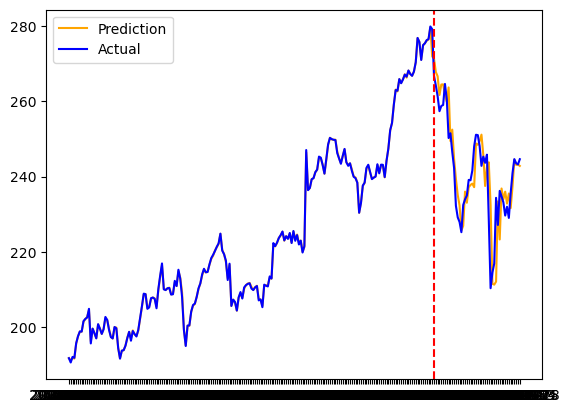

In [ ]:
plt.plot(df["date"], y_pred, color="orange")
plt.plot(df["date"], df[RESPONSE_VAR], color = "blue")
plt.legend(labels=["Prediction", "Actual"])
plt.axvline(TEST_START_INDEX, color="red", linestyle="--")

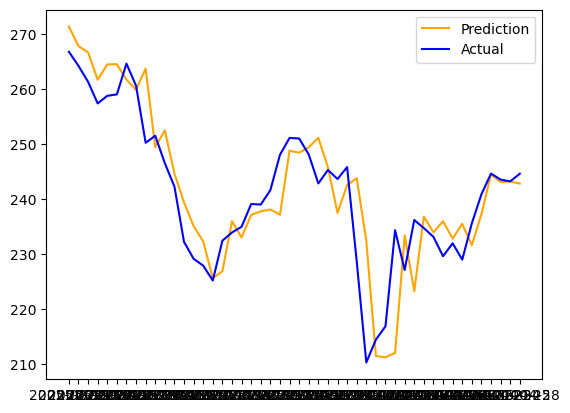

In [ ]:
plt.plot(df.loc[TEST_START_INDEX:, "date"], y_pred[TEST_START_INDEX:], color="orange")
plt.plot(df.loc[TEST_START_INDEX:, "date"], df.loc[TEST_START_INDEX:, RESPONSE_VAR], color = "blue")
plt.legend(labels=["Prediction", "Actual"])

## Testing strategy vs. Buy and Hold

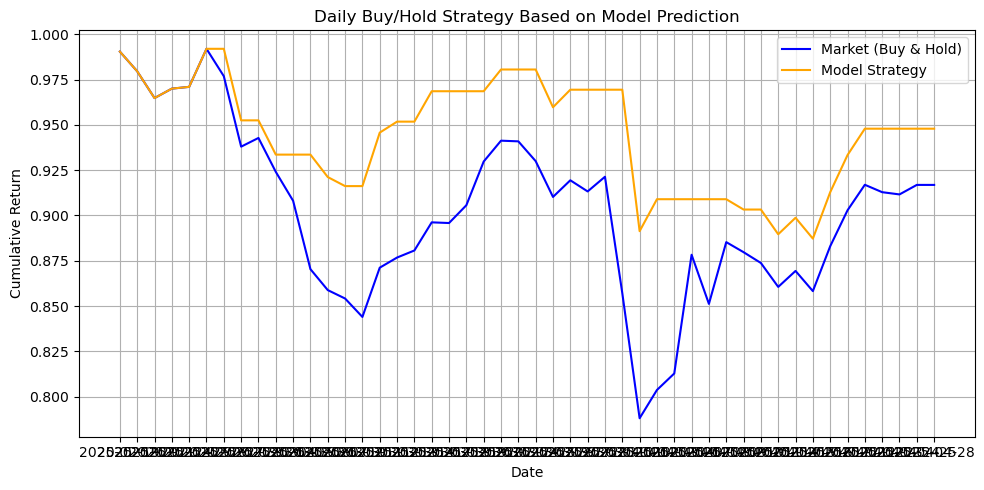

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume y_pred is an array of predicted close prices
# Assume df contains 'date' and actual close price in RESPONSE_VAR
# Assume TEST_START_INDEX is the starting index of your OOT predictions

# 1. Extract test window
test_df = df.iloc[TEST_START_INDEX:].copy()
test_df["prediction"] = y_pred[TEST_START_INDEX:]

# 2. Calculate next-day return from actual closes
test_df["actual_close_t"] = test_df[RESPONSE_VAR]
test_df["actual_close_t+1"] = test_df["actual_close_t"].shift(-1)
test_df["actual_return"] = (test_df["actual_close_t+1"] - test_df["actual_close_t"]) / test_df["actual_close_t"]

# 3. Calculate model's expected return
test_df["predicted_return"] = (test_df["prediction"].shift(-1) - test_df["actual_close_t"]) / test_df["actual_close_t"]

# 4. Define buy signal: model predicts next-day return > 0
test_df["signal"] = (test_df["predicted_return"] > 0).astype(int)

# 5. Calculate strategy return: earn return only when signal == 1
test_df["strategy_return"] = test_df["actual_return"] * test_df["signal"]

# 6. Calculate cumulative returns
test_df["cumulative_market"] = (1 + test_df["actual_return"].fillna(0)).cumprod()
test_df["cumulative_strategy"] = (1 + test_df["strategy_return"].fillna(0)).cumprod()

# 7. Plot results
plt.figure(figsize=(10, 5))
plt.plot(test_df["date"], test_df["cumulative_market"], label="Market (Buy & Hold)", color='blue')
plt.plot(test_df["date"], test_df["cumulative_strategy"], label="Model Strategy", color='orange')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Daily Buy/Hold Strategy Based on Model Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()
